# Iterative Simplification - MNIST Dataset

## Model

In [1]:
import numpy as np
import importlib
import random
import math
import json
import gc

import auxiliar_functions as af

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as clr

from matplotlib.colorbar import ColorbarBase

from keras.datasets import cifar10, mnist
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.utils import np_utils
from keras.optimizers import SGD, Adadelta
from keras.losses import categorical_crossentropy
from keras.utils import to_categorical

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AffinityPropagation, MeanShift, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.stats import mode

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

input_shape = x_train.shape[1:]
num_classes = y_train.shape[1]

labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [3]:
model = load_model('models/mnist_16c_16c_16d.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                50192     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
Total params: 52,842
Trainable params: 52,842
Non-trainable params: 0
_________________________________________________________________


In [4]:
p_labels = np.argmax(model.predict(x_train), axis=1) # Predicted labels for training set.
t_labels = np.argmax(y_train, axis=1) # True labels for training set.

scores = model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 96.96%


In [5]:
colors1 = cm.autumn(np.linspace(0., 1, 128))
colors2 = cm.cool(np.linspace(0, 1, 128))
colors = np.vstack((colors1, colors2))
mymap = clr.LinearSegmentedColormap.from_list('my_colormap', colors)

# 1st Layer Analysis

In [6]:
h0, _ = af.class_histogram_conv2d_v3(model, 0, x_train, t_labels, p_labels, num_classes)
h0.shape

(16, 28, 28, 10)

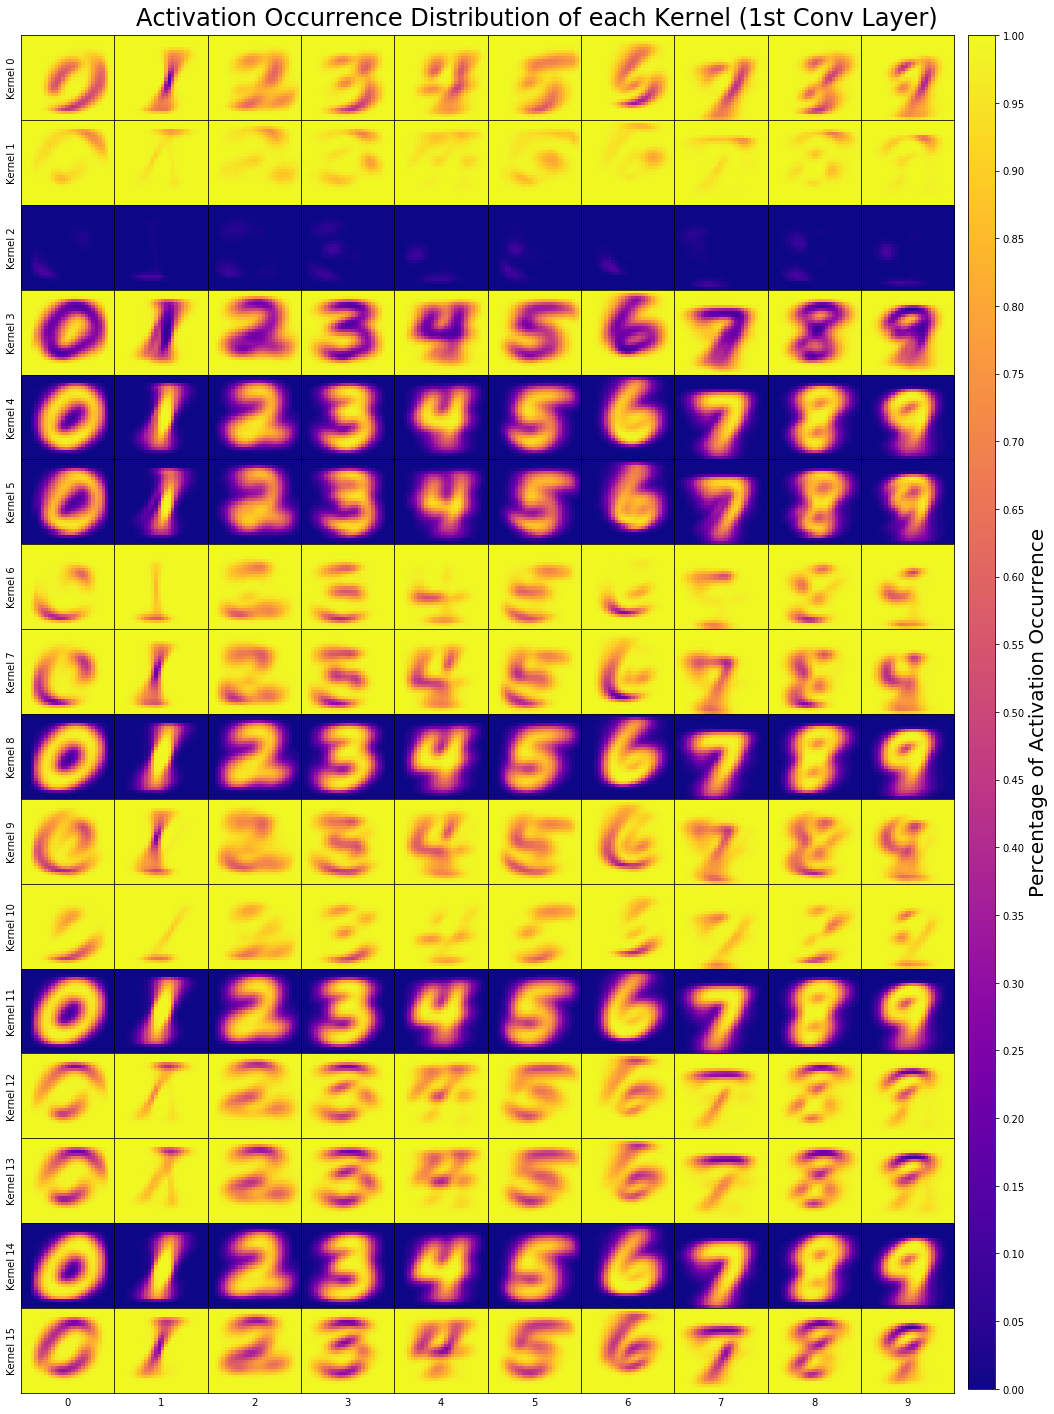

In [7]:
n_rows = h0.shape[0]
n_cols = h0.shape[3]

f, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 20))

f.suptitle('Activation Occurrence Distribution of each Kernel (1st Conv Layer)', fontsize=24)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        im = axs[i, j].imshow(h0[i, :, :, j], aspect='auto', cmap=cm.plasma, vmin=0.0, vmax=1.0)
        
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        
        if j == 0:
            axs[i, j].set_ylabel('Kernel ' + str(i))
        
        if i == axs.shape[0]-1:
            axs[i, j].set_xlabel(labels[j])

f.tight_layout(rect=[0, 0, 0.9, 0.97])
plt.subplots_adjust(wspace=0.0, hspace=0.0)

cbar_ax = f.add_axes([0.9, 0.02, 0.025, 0.94])
cbar = f.colorbar(im, cax=cbar_ax, ticks=[0.05*x for x in range(21)])
cbar.set_label('Percentage of Activation Occurrence', fontsize=20)

In [8]:
clustering = AgglomerativeClustering(n_clusters=h0.shape[0], 
                                     compute_full_tree=True).fit(h0.reshape((h0.shape[0],
                                                                        h0.shape[1]*h0.shape[2]*h0.shape[3])))

merge_order = clustering.children_
index_list = [[i] for i in range(h0.shape[0])]

for i, j in merge_order:
    index_list.append(index_list[i] + index_list[j])

h0o = index_list[-1]
h0s = h0[h0o, :]
h0s.shape, len(h0o)

((16, 28, 28, 10), 16)

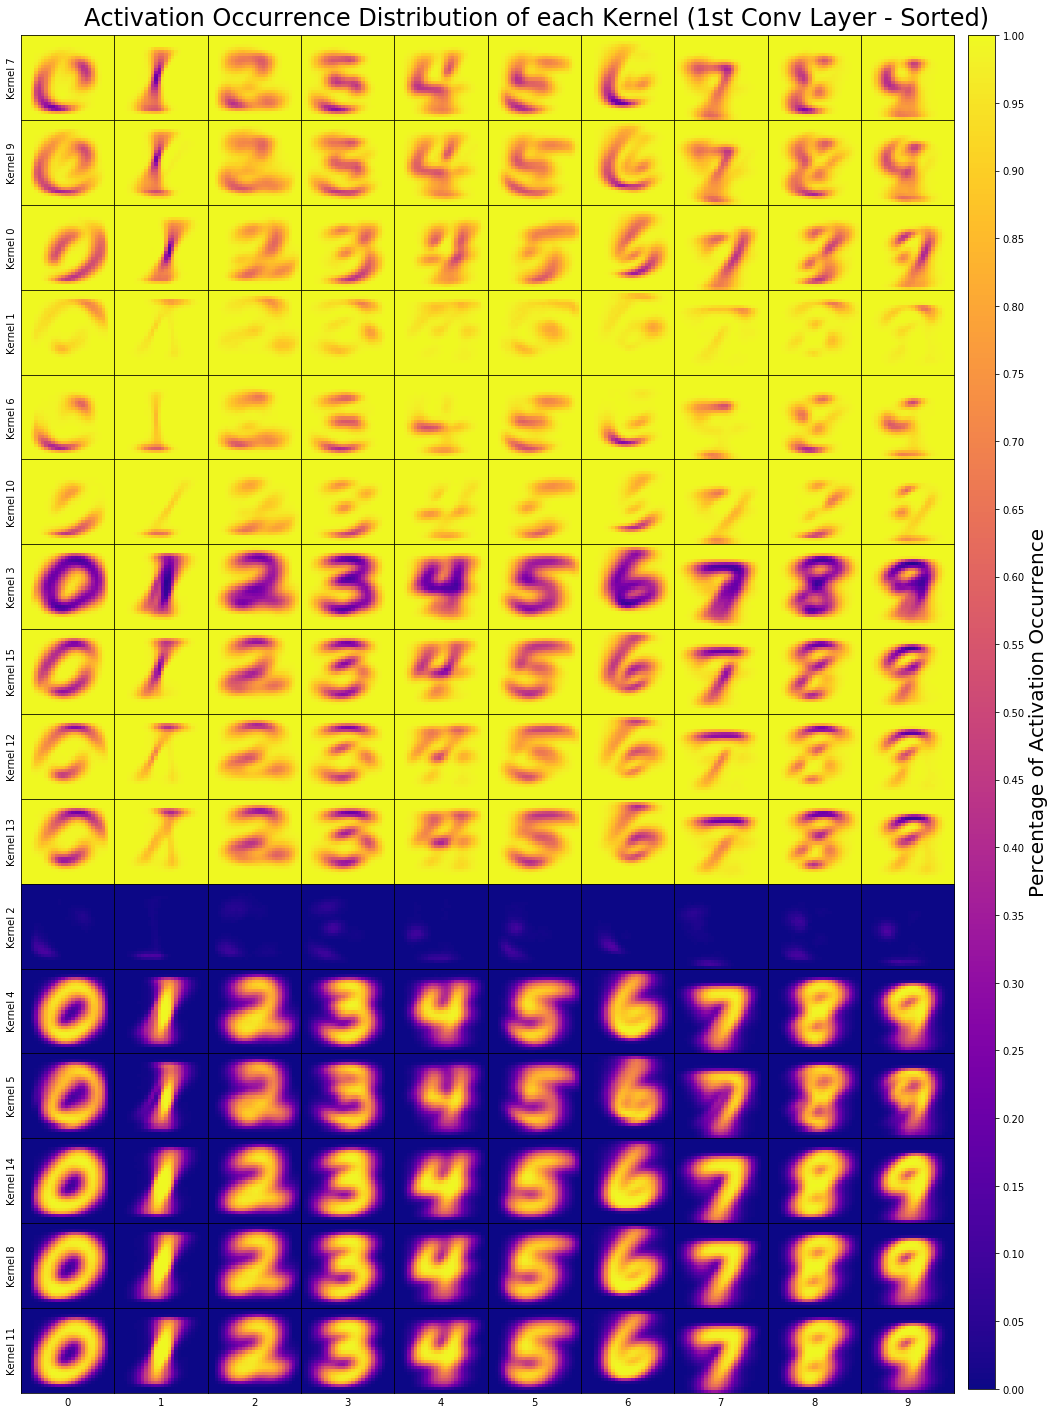

In [9]:
n_rows = h0s.shape[0]
n_cols = h0s.shape[3]

f, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 20))

f.suptitle('Activation Occurrence Distribution of each Kernel (1st Conv Layer - Sorted)', fontsize=24)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        im = axs[i, j].imshow(h0s[i, :, :, j], aspect='auto', cmap=cm.plasma, vmin=0.0, vmax=1.0)
        
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        
        if j == 0:
            axs[i, j].set_ylabel('Kernel ' + str(h0o[i]))
        
        if i == axs.shape[0]-1:
            axs[i, j].set_xlabel(labels[j])

f.tight_layout(rect=[0, 0, 0.9, 0.97])
plt.subplots_adjust(wspace=0.0, hspace=0.0)

cbar_ax = f.add_axes([0.9, 0.02, 0.025, 0.94])
cbar = f.colorbar(im, cax=cbar_ax, ticks=[0.05*x for x in range(21)])
cbar.set_label('Percentage of Activation Occurrence', fontsize=20)

## Positional Class Selectivity

In [10]:
h0 = af.merge_pixels_dim(h0)
h0.shape

(16, 784, 10)

In [11]:
dch0 = af.position_class_selectivity(h0)
dch0.shape

(16, 784, 10)

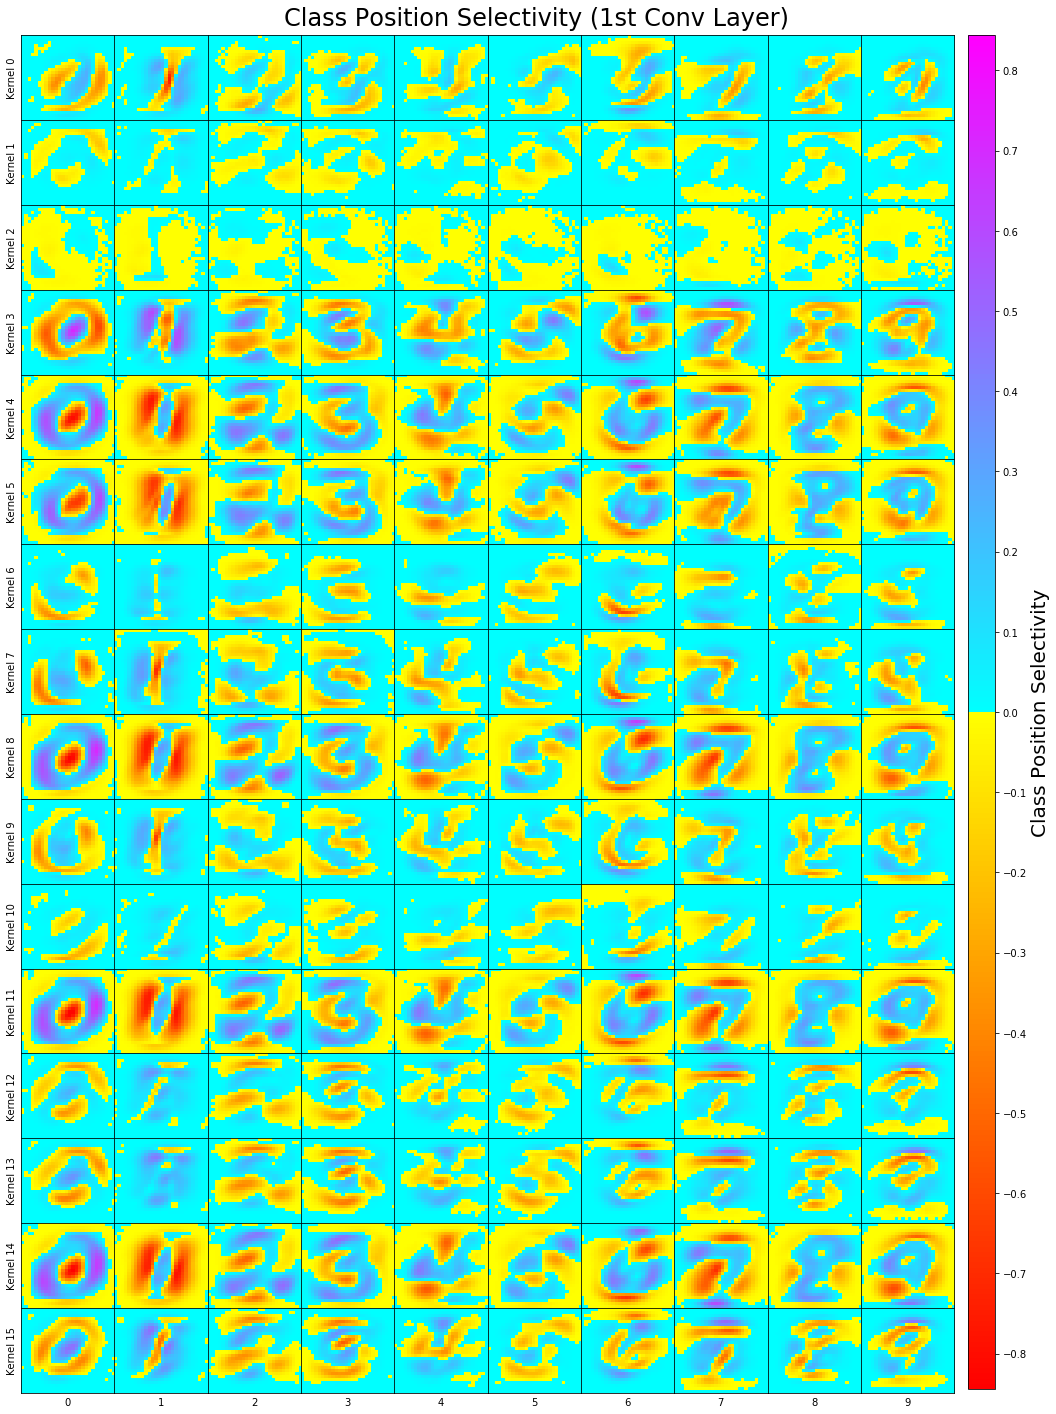

In [12]:
vlim = np.max(np.abs(dch0))

n_rows = dch0.shape[0]
n_cols = dch0.shape[2]

f, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 20))

f.suptitle('Class Position Selectivity (1st Conv Layer)', fontsize=24)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        im = axs[i, j].imshow(dch0[i,:,j].reshape((28,28)), aspect='auto', cmap=mymap, vmin=-vlim, vmax=vlim)
        
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        
        if j == 0:
            axs[i, j].set_ylabel('Kernel ' + str(i))
        
        if i == axs.shape[0]-1:
            axs[i, j].set_xlabel(labels[j])

f.tight_layout(rect=[0, 0, 0.9, 0.97])
plt.subplots_adjust(wspace=0.0, hspace=0.0)

cbar_ax = f.add_axes([0.9, 0.02, 0.025, 0.94])
cbar = f.colorbar(im, cax=cbar_ax, ticks=[0.1*x-1.0 for x in range(21)])
cbar.set_label('Class Position Selectivity', fontsize=20)

In [13]:
clustering = AgglomerativeClustering(n_clusters=dch0.shape[0], 
                                     compute_full_tree=True).fit(dch0.reshape((16, 28*28*10)))

merge_order = clustering.children_
index_list = [[i] for i in range(dch0.shape[0])]

for i, j in merge_order:
    index_list.append(index_list[i] + index_list[j])

dch0o = index_list[-1]
dch0s = dch0[dch0o, :]
dch0s.shape, len(dch0o)

((16, 784, 10), 16)

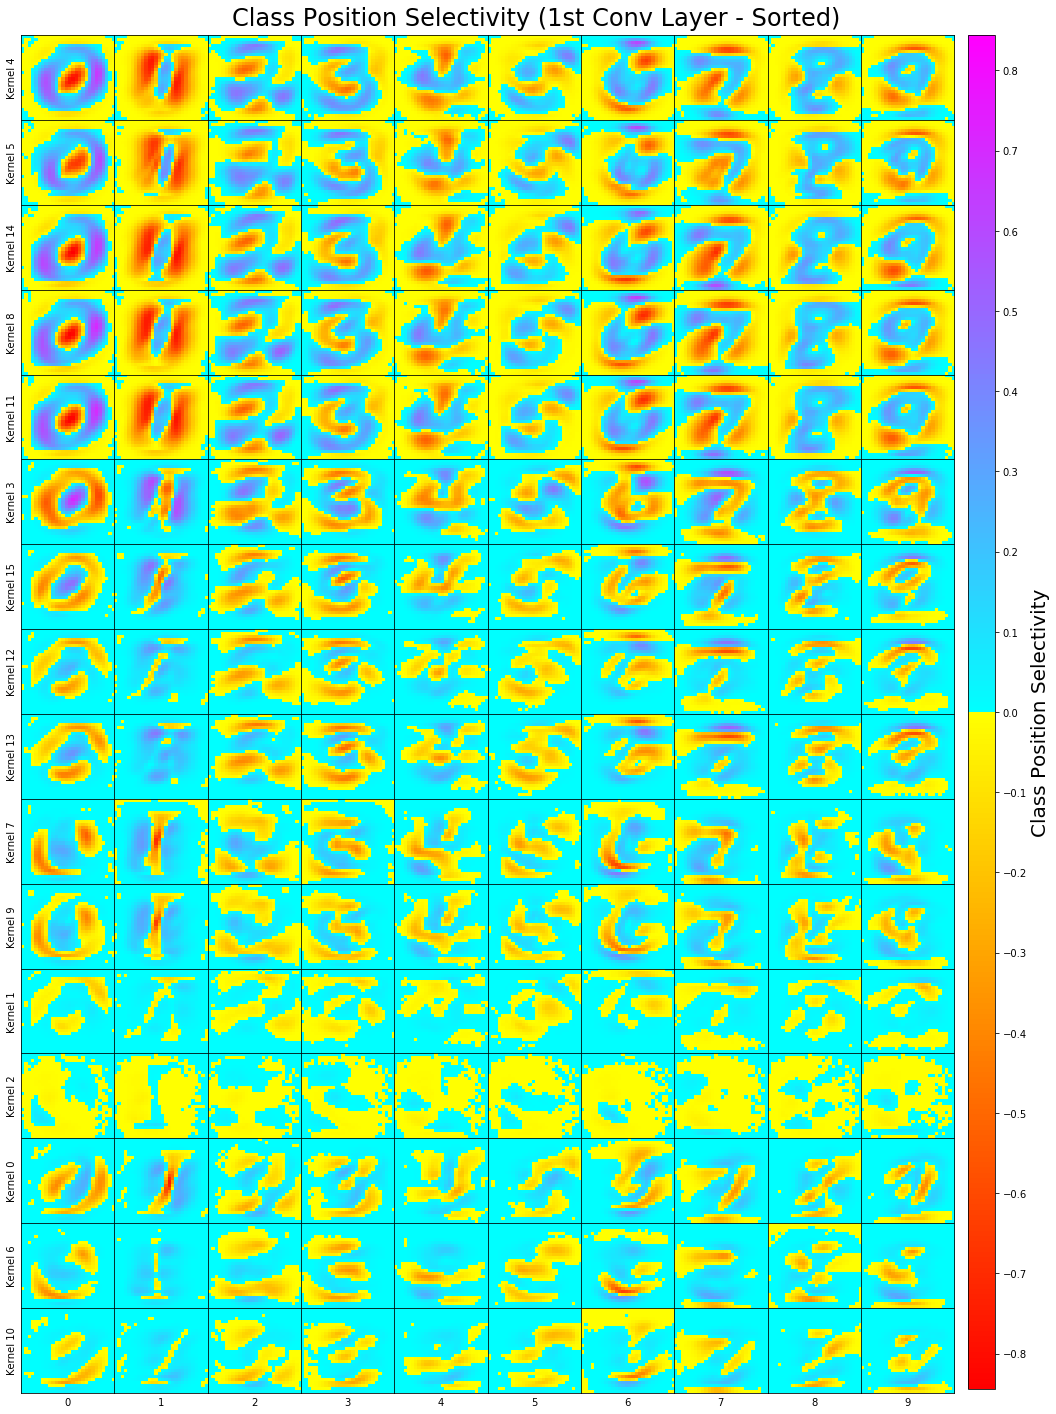

In [14]:
vlim = np.max(np.abs(dch0s))

n_rows = dch0s.shape[0]
n_cols = dch0s.shape[2]

f, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 20))

f.suptitle('Class Position Selectivity (1st Conv Layer - Sorted)', fontsize=24)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i, j].imshow(dch0s[i, :, j].reshape((28,28)), aspect='auto', cmap=mymap, vmin=-vlim, vmax=vlim)
        
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        
        if j == 0:
            axs[i, j].set_ylabel('Kernel ' + str(dch0o[i]))
        
        if i == axs.shape[0]-1:
            axs[i, j].set_xlabel(labels[j])

f.tight_layout(rect=[0, 0, 0.9, 0.97])
plt.subplots_adjust(wspace=0.0, hspace=0.0)

cbar_ax = f.add_axes([0.9, 0.02, 0.025, 0.94])
cbar = f.colorbar(im, cax=cbar_ax, ticks=[0.1*x-1.0 for x in range(21)])
cbar.set_label('Class Position Selectivity', fontsize=20)

## Kernel Comparison

In [15]:
dm_sb = np.zeros((h0.shape[0], h0.shape[0]))

for k1 in range(h0.shape[0]):
    for k2 in range(h0.shape[0]):
        dm_sb[k1, k2] = np.mean(np.abs(h0[k1, :, :] - h0[k2, :, :]))

dm_sb.shape

(16, 16)

In [16]:
dm_sb_o = [4,5,8,11,14,12,13,3,15,7,9,0,1,2,6,10]
dm_sb_s = dm_sb[dm_sb_o, :]
dm_sb_s = dm_sb_s[:, dm_sb_o]

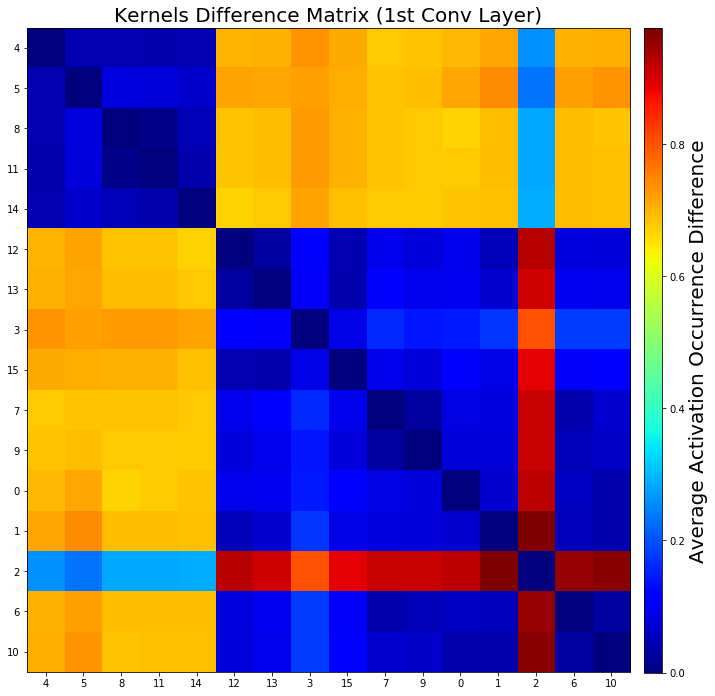

In [17]:
f, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(dm_sb_s, aspect='auto', cmap=cm.jet)

ax.set_xticks([i for i in range(len(dm_sb_o))])
ax.set_xticklabels(dm_sb_o)

ax.set_yticks([i for i in range(len(dm_sb_o))])
ax.set_yticklabels(dm_sb_o)

ax.set_title('Kernels Difference Matrix (1st Conv Layer)', fontsize=20)

f.tight_layout(rect=[0, 0, 0.9, 0.9775])
plt.subplots_adjust(wspace=0.0, hspace=0.0)

cbar_ax = f.add_axes([0.9, 0.0375, 0.025, 0.895])
cbar = f.colorbar(im, cax=cbar_ax)
cbar.set_label('Average Activation Occurrence Difference', fontsize=20)

In [72]:
model_v1.save('models/mnist_16c_16c_16d_v1.h5')

In [18]:
model = load_model('models/mnist_16c_16c_16d_v1.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 5)         50        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 16)        736       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                50192     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                170       
Total params: 51,148
Trainable params: 51,098
Non-trainable params: 50
_________________________________________________________________


In [19]:
p_labels = np.argmax(model.predict(x_train), axis=1) # Predicted labels for training set.
t_labels = np.argmax(y_train, axis=1) # True labels for training set.

scores = model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 96.93%


In [20]:
model_v1 = model

# 2nd Layer Analysis

In [21]:
h0, _ = af.class_histogram_conv2d_v3(model_v1, 1, x_train, t_labels, p_labels, num_classes)
h0.shape

(16, 28, 28, 10)

In [22]:
h0border = np.array(h0)
h0 = h0[:, 1:-1, 1:-1, :]
h0.shape

(16, 26, 26, 10)

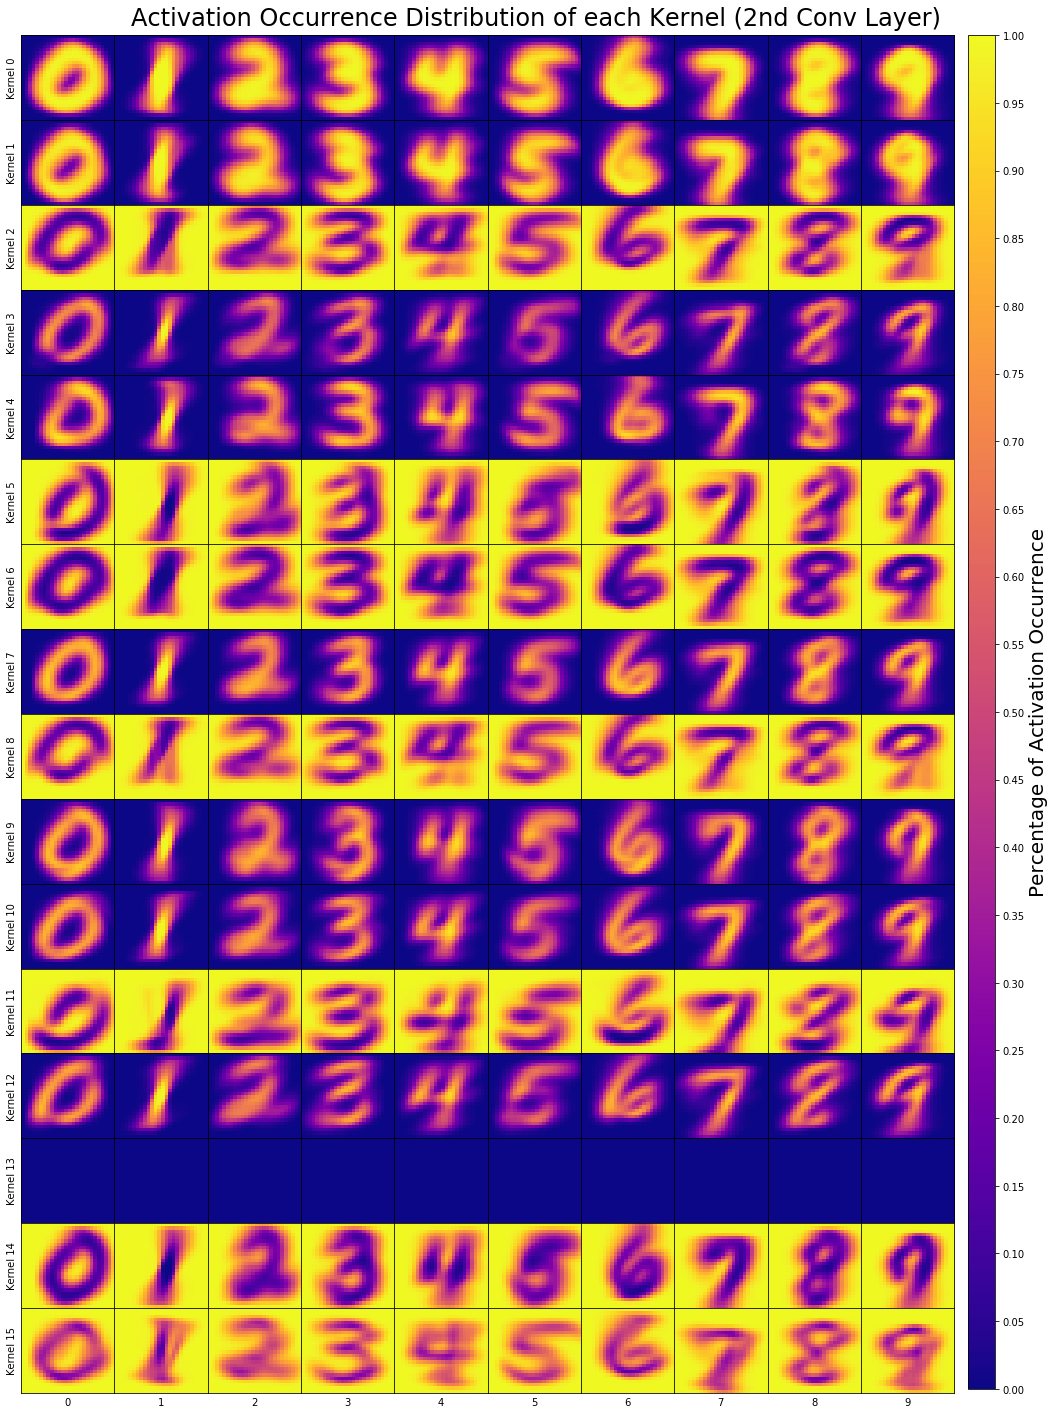

In [23]:
n_rows = h0.shape[0]
n_cols = h0.shape[3]

f, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 20))

f.suptitle('Activation Occurrence Distribution of each Kernel (2nd Conv Layer)', fontsize=24)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        im = axs[i, j].imshow(h0[i, :, :, j], aspect='auto', cmap=cm.plasma, vmin=0.0, vmax=1.0)
        
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        
        if j == 0:
            axs[i, j].set_ylabel('Kernel ' + str(i))
        
        if i == axs.shape[0]-1:
            axs[i, j].set_xlabel(labels[j])

f.tight_layout(rect=[0, 0, 0.9, 0.97])
plt.subplots_adjust(wspace=0.0, hspace=0.0)

cbar_ax = f.add_axes([0.9, 0.02, 0.025, 0.94])
cbar = f.colorbar(im, cax=cbar_ax, ticks=[0.05*x for x in range(21)])
cbar.set_label('Percentage of Activation Occurrence', fontsize=20)

In [24]:
clustering = AgglomerativeClustering(n_clusters=h0.shape[0], 
                                     compute_full_tree=True).fit(h0.reshape((h0.shape[0],
                                                                        h0.shape[1]*h0.shape[2]*h0.shape[3])))

merge_order = clustering.children_
index_list = [[i] for i in range(h0.shape[0])]

for i, j in merge_order:
    index_list.append(index_list[i] + index_list[j])

h0o = index_list[-1]
h0s = h0[h0o, :]
h0s.shape, len(h0o)

((16, 26, 26, 10), 16)

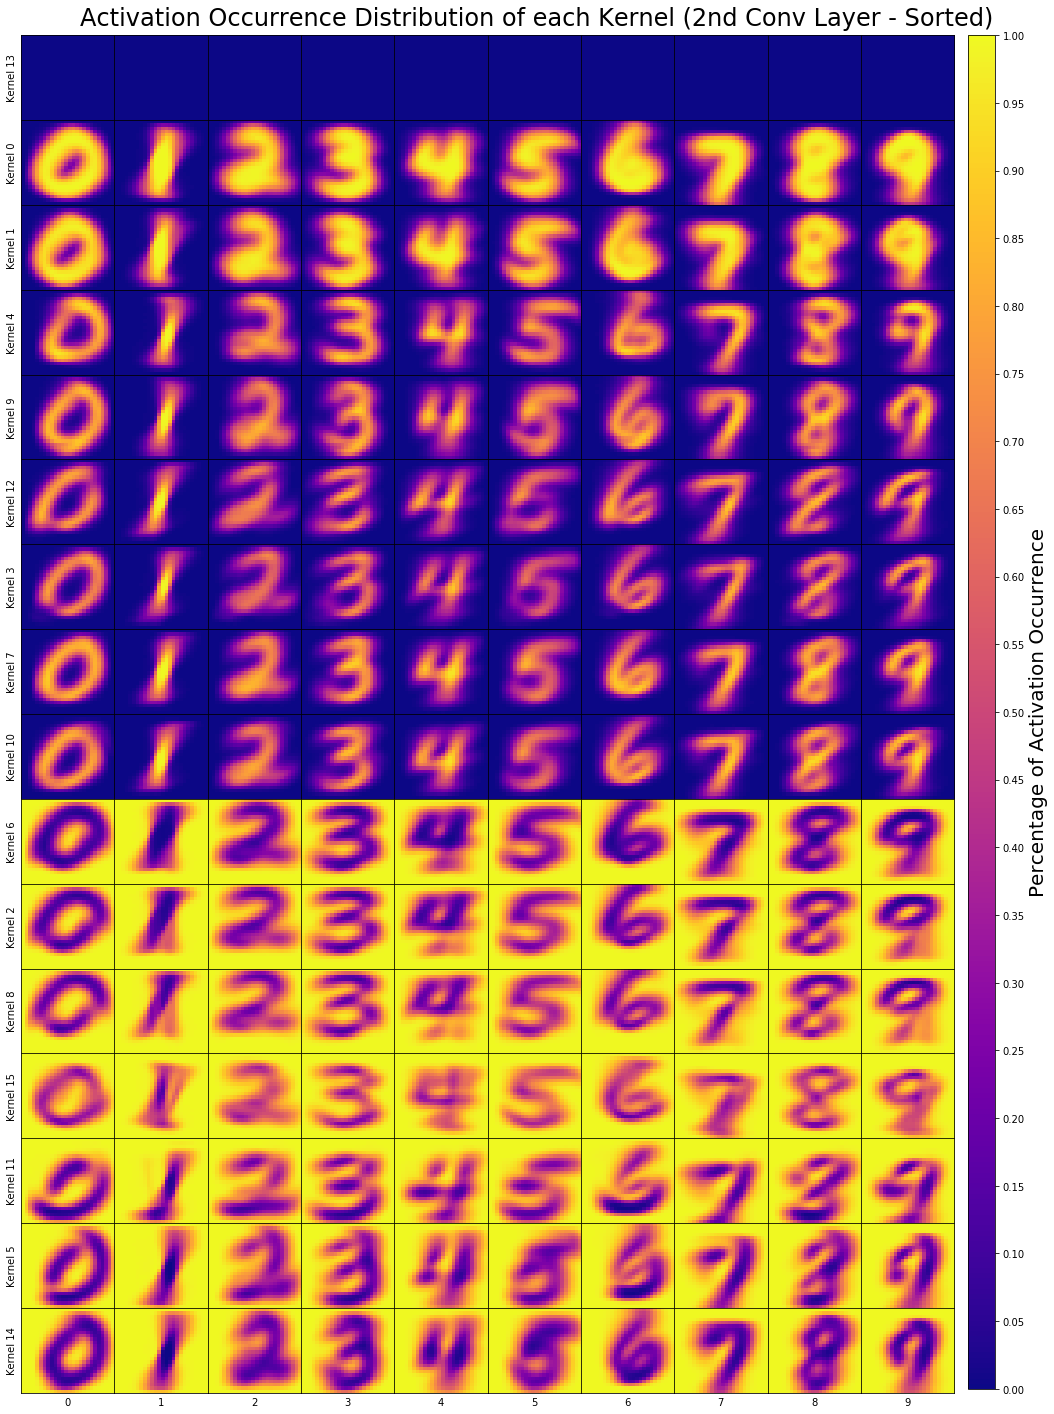

In [25]:
n_rows = h0s.shape[0]
n_cols = h0s.shape[3]

f, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 20))

f.suptitle('Activation Occurrence Distribution of each Kernel (2nd Conv Layer - Sorted)', fontsize=24)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        im = axs[i, j].imshow(h0s[i, :, :, j], aspect='auto', cmap=cm.plasma, vmin=0.0, vmax=1.0)
        
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        
        if j == 0:
            axs[i, j].set_ylabel('Kernel ' + str(h0o[i]))
        
        if i == axs.shape[0]-1:
            axs[i, j].set_xlabel(labels[j])

f.tight_layout(rect=[0, 0, 0.9, 0.97])
plt.subplots_adjust(wspace=0.0, hspace=0.0)

cbar_ax = f.add_axes([0.9, 0.02, 0.025, 0.94])
cbar = f.colorbar(im, cax=cbar_ax, ticks=[0.05*x for x in range(21)])
cbar.set_label('Percentage of Activation Occurrence', fontsize=20)

## Positional Class Selectivity

In [26]:
h0 = af.merge_pixels_dim(h0)
h0.shape

(16, 676, 10)

In [27]:
dch0 = af.position_class_selectivity(h0)
dch0.shape

(16, 676, 10)

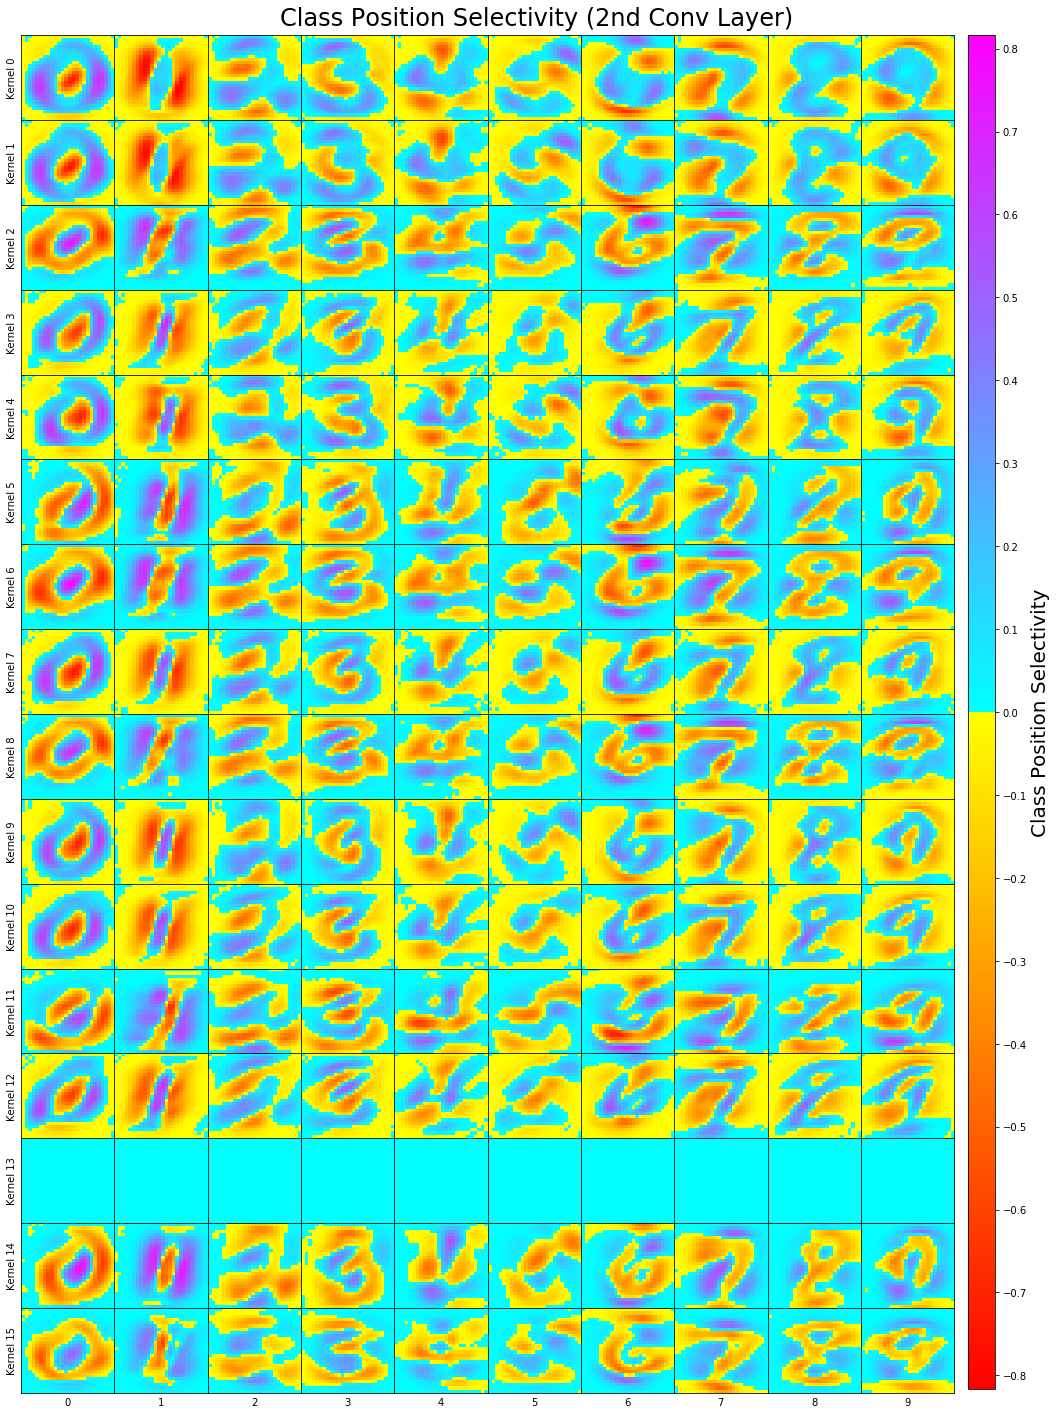

In [28]:
vlim = np.max(np.abs(dch0))

n_rows = dch0.shape[0]
n_cols = dch0.shape[2]

f, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 20))

f.suptitle('Class Position Selectivity (2nd Conv Layer)', fontsize=24)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        im = axs[i, j].imshow(dch0[i,:,j].reshape((26,26)), aspect='auto', cmap=mymap, vmin=-vlim, vmax=vlim)
        
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        
        if j == 0:
            axs[i, j].set_ylabel('Kernel ' + str(i))
        
        if i == axs.shape[0]-1:
            axs[i, j].set_xlabel(labels[j])

f.tight_layout(rect=[0, 0, 0.9, 0.97])
plt.subplots_adjust(wspace=0.0, hspace=0.0)

cbar_ax = f.add_axes([0.9, 0.02, 0.025, 0.94])
cbar = f.colorbar(im, cax=cbar_ax, ticks=[0.1*x-1.0 for x in range(21)])
cbar.set_label('Class Position Selectivity', fontsize=20)

In [29]:
clustering = AgglomerativeClustering(n_clusters=dch0.shape[0], 
                                     compute_full_tree=True).fit(dch0.reshape((16, 26*26*10)))

merge_order = clustering.children_
index_list = [[i] for i in range(dch0.shape[0])]

for i, j in merge_order:
    index_list.append(index_list[i] + index_list[j])

dch0o = index_list[-1]
dch0s = dch0[dch0o, :]
dch0s.shape, len(dch0o)

((16, 676, 10), 16)

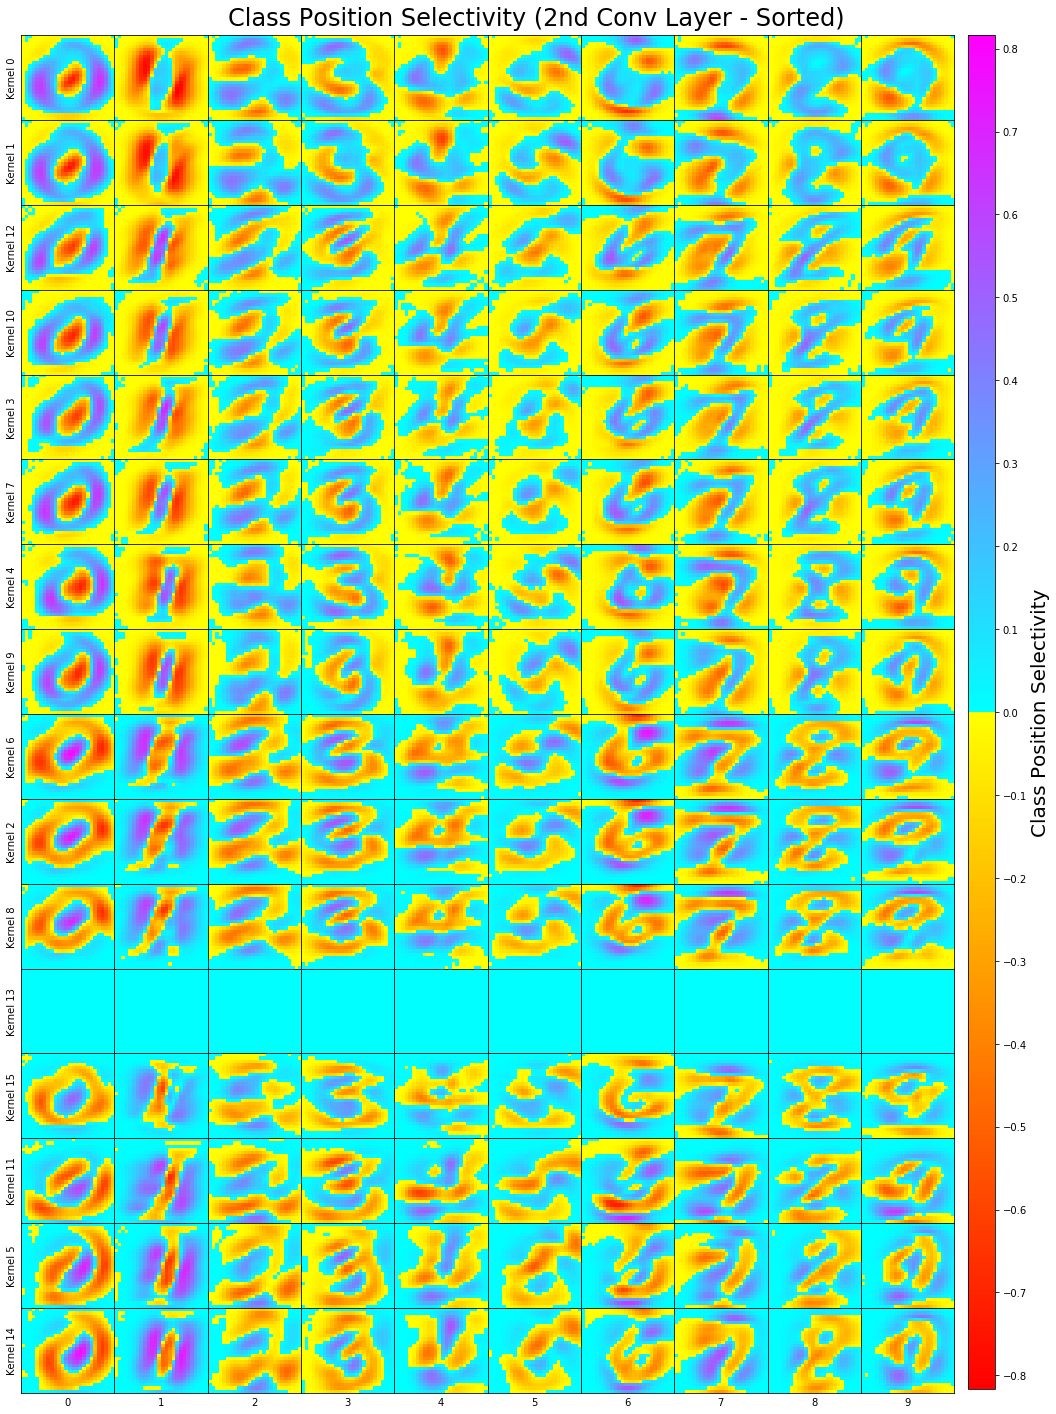

In [30]:
vlim = np.max(np.abs(dch0s))

n_rows = dch0s.shape[0]
n_cols = dch0s.shape[2]

f, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 20))

f.suptitle('Class Position Selectivity (2nd Conv Layer - Sorted)', fontsize=24)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i, j].imshow(dch0s[i, :, j].reshape((26,26)), aspect='auto', cmap=mymap, vmin=-vlim, vmax=vlim)
        
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        
        if j == 0:
            axs[i, j].set_ylabel('Kernel ' + str(dch0o[i]))
        
        if i == axs.shape[0]-1:
            axs[i, j].set_xlabel(labels[j])

f.tight_layout(rect=[0, 0, 0.9, 0.97])
plt.subplots_adjust(wspace=0.0, hspace=0.0)

cbar_ax = f.add_axes([0.9, 0.02, 0.025, 0.94])
cbar = f.colorbar(im, cax=cbar_ax, ticks=[0.1*x-1.0 for x in range(21)])
cbar.set_label('Class Position Selectivity', fontsize=20)

## Kernel Comparison

In [31]:
dm_sb = np.zeros((h0.shape[0], h0.shape[0]))

for k1 in range(h0.shape[0]):
    for k2 in range(h0.shape[0]):
        dm_sb[k1, k2] = np.mean(np.abs(h0[k1, :, :] - h0[k2, :, :]))

dm_sb.shape

(16, 16)

In [33]:
dm_sb_o = [0, 1, 7, 10, 12, 2, 6, 8, 11, 15, 4, 9, 3, 5, 14, 13]
dm_sb_s = dm_sb[dm_sb_o, :]
dm_sb_s = dm_sb_s[:, dm_sb_o]

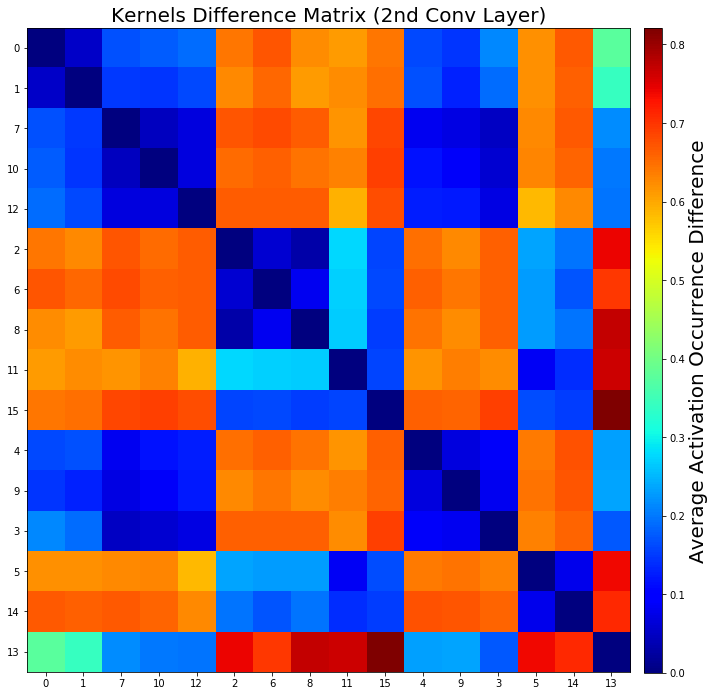

In [34]:
f, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(dm_sb_s, aspect='auto', cmap=cm.jet)

ax.set_xticks([i for i in range(len(dm_sb_o))])
ax.set_xticklabels(dm_sb_o)

ax.set_yticks([i for i in range(len(dm_sb_o))])
ax.set_yticklabels(dm_sb_o)

ax.set_title('Kernels Difference Matrix (2nd Conv Layer)', fontsize=20)

f.tight_layout(rect=[0, 0, 0.9, 0.9775])
plt.subplots_adjust(wspace=0.0, hspace=0.0)

cbar_ax = f.add_axes([0.9, 0.0375, 0.025, 0.895])
cbar = f.colorbar(im, cax=cbar_ax)
cbar.set_label('Average Activation Occurrence Difference', fontsize=20)

## Kernel Selectivity

In [90]:
dch0p = dch0
dch0p = np.mean(dch0p, axis=1)

ks_h0_sum = np.zeros((dch0p.shape[0],))

for k in range(dch0p.shape[0]):
    avg_l = []
    
    for i in range(dch0p.shape[1]):
        for j in range(i+1, dch0p.shape[1]):
            avg_l.append(dch0p[k, i] - dch0p[k, j])
        
    ks_h0_sum[k] = np.mean(np.abs(avg_l))

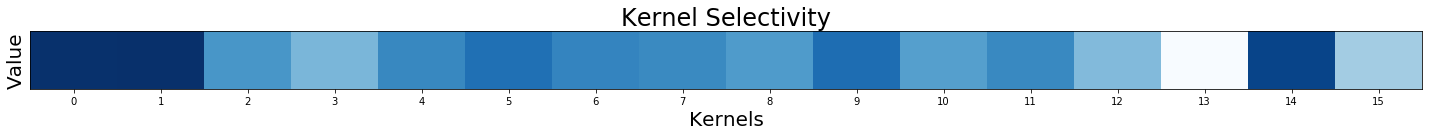

In [91]:
f, ax = plt.subplots(figsize=(20, 2))

ax.imshow(ks_h0_sum.reshape((ks_h0_sum.shape[0], 1)).T, aspect='auto', cmap=cm.Blues)

ax.set_xticks([i for i in range(len(ks_h0_sum))])
ax.set_yticks([])

ax.set_title('Kernel Selectivity', fontsize=24)
ax.set_xlabel('Kernels', fontsize=20)
ax.set_ylabel('Value', fontsize=20)

f.tight_layout(rect=[0, 0, 1, 1])

## Removal Experiments

In [92]:
groups = [[0,1],[4],[7,10],[9],[12],[3],[2,6,8],[5],[11],[14],[15]] # thrash: 13
len(groups)

11

In [93]:
# np.sort(np.array([x for g in groups for x in g])) == [i for i in range(64)]

In [94]:
remains = []

for g in groups:
    sel = [ks_h0_sum[x] for x in g]
    chosen = np.argmax(sel)
    remains.append(g[chosen])

remains = np.array(remains)
    
print(len(remains), remains)

11 [ 1  4  7  9 12  3  6  5 11 14 15]


In [98]:
model_v2 = af.reduce_model_units(model_v1, 1, remains)
scores = model_v2.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 89.91%


In [99]:
model_v2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 5)         50        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 11)        506       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 11)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2156)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                34512     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                170       
Total params: 35,238
Trainable params: 34,682
Non-trainable params: 556
_________________________________________________________________


In [100]:
h = model_v2.fit(x_train, y_train, batch_size=128, epochs=1, verbose=1, validation_split=0.1, shuffle=True)

Train on 54000 samples, validate on 6000 samples
Epoch 1/1
54000/54000 [==============================] - 23s 421us/step - loss: 0.1038 - acc: 0.9713 - val_loss: 0.0752 - val_acc: 0.9817


In [101]:
scores = model_v2.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 97.69%


In [102]:
model_v2.save('models/mnist_16c_16c_16d_v2.h5')